### STEP 1:Import libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### STEP 2: Load Dataset

In [16]:
df = pd.read_csv("Cleaned Dataset.csv")
df.head()


,id,screen_name,description_clean,location_clean,followers_scaled,friends_scaled,favourites_scaled,verified,label,lang
0,7.874060e+17,best_in_dumbest,blame xaiax inspired by makinginvisible using ...,unknown,7.371489,1.609438,1.609438,0,1,en
1,7.962160e+17,CJRubinPhoto,photographing the american west since 1980 i s...,estados unidos,6.758095,6.781058,6.285998,0,0,en
2,8.759500e+17,SVGEGENT,scruffy looking nerf herder and twitch broadca...,los angeles ca,5.153292,6.388561,8.104099,0,0,en
3,7.561200e+17,TinkerVHELPK5,wife godmother friend feline fanatic assistant...,birmingham al,6.249975,6.452049,9.040026,0,0,en
4,4.647813e+08,JoleonLescott,loan coach at mancity aspiring dj,england united kingdom,13.532722,4.762174,4.488636,0,0,en


### STEP 3:Understand Dataset

In [17]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 37434 non-null  float64
 1   screen_name        37434 non-null  object 
 2   description_clean  28595 non-null  object 
 3   location_clean     36782 non-null  object 
 4   followers_scaled   37434 non-null  float64
 5   friends_scaled     37434 non-null  float64
 6   favourites_scaled  37434 non-null  float64
 7   verified           37434 non-null  int64  
 8   label              37434 non-null  int64  
 9   lang               37434 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 2.9+ MB


### STEP 4: Clean Dataset

In [18]:
#Removing unnecessary columns

### Removing Identifier Columns

The columns `id` and `screen_name` are unique identifiers and do not represent user behavior. Including them could cause the model to memorize specific accounts instead of learning general patterns. Therefore, they are removed to focus on meaningful behavioral features.


In [19]:
df = df.drop(columns=["id", "screen_name"])


### Handling Missing Values

Some text fields in the dataset contain missing values. Machine learning models cannot process missing text directly, so we replace empty descriptions with blank strings and unknown locations/languages with a placeholder value. This ensures consistency and prevents errors during feature extraction.


In [21]:
df["description_clean"] = df["description_clean"].fillna("")
df["location_clean"] = df["location_clean"].fillna("unknown")
df["lang"] = df["lang"].fillna("unknown")


### STEP 5: FEATURE ENGINEERING

### Creating Behavioral Ratio Features

Three ratio-based features are created to describe account interaction behavior:

* **follower_friend_ratio** measures the balance between followers and friends, which can reveal abnormal social patterns.
* **engagement_score** estimates how actively an account interacts relative to its audience size.
* **social_balance** captures the difference between followers and friends, highlighting extreme imbalances.

These features focus on behavioral relationships instead of raw counts.


In [26]:
# Create a ratio of followers to friends to measure social balance.
# +1 is added to avoid division by zero when friends_scaled is 0.
df["follower_friend_ratio"] = df["followers_scaled"] / (df["friends_scaled"] + 1)

# Estimate engagement level by comparing favorites to followers.
# +1 prevents division by zero when followers_scaled is 0.
df["engagement_score"] = df["favourites_scaled"] / (df["followers_scaled"] + 1)

# Calculate the absolute difference between followers and friends.
# This highlights accounts with extreme social imbalance.
df["social_balance"] = abs(df["followers_scaled"] - df["friends_scaled"])



### Extracting Text Behavior Features

Text-based features are extracted from account descriptions:

* **desc_length** measures the total length of the description.
* **word_count** counts the number of words in the description.
* **empty_desc** flags accounts with missing or empty descriptions.

These features help identify low-effort or incomplete profiles.


In [27]:
df["desc_length"] = df["description_clean"].apply(len)
df["word_count"] = df["description_clean"].apply(lambda x: len(x.split()))
df["empty_desc"] = df["description_clean"].apply(lambda x: 1 if x == "" else 0)


### Encoding Location Availability

The feature **unknown_location** is a binary flag indicating whether location information is missing or labeled as unknown. Incomplete profile details can act as a signal of suspicious accounts.


In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["lang_encoded"] = encoder.fit_transform(df["lang"])


In [29]:
df.head()

,description_clean,location_clean,followers_scaled,friends_scaled,favourites_scaled,verified,label,lang,follower_friend_ratio,engagement_score,social_balance,desc_length,word_count,empty_desc,lang_encoded
0,blame xaiax inspired by makinginvisible using ...,unknown,7.371489,1.609438,1.609438,0,1,en,2.824934,0.192252,5.762051,123,18,0,6
1,photographing the american west since 1980 i s...,estados unidos,6.758095,6.781058,6.285998,0,0,en,0.868532,0.810250,0.022963,150,21,0,6
2,scruffy looking nerf herder and twitch broadca...,los angeles ca,5.153292,6.388561,8.104099,0,0,en,0.697469,1.317035,1.235270,77,11,0,6
3,wife godmother friend feline fanatic assistant...,birmingham al,6.249975,6.452049,9.040026,0,0,en,0.838692,1.246904,0.202074,95,12,0,6
4,loan coach at mancity aspiring dj,england united kingdom,13.532722,4.762174,4.488636,0,0,en,2.348544,0.308864,8.770548,33,6,0,6


### STEP 6: DEFINING FEATURES AND TARGET

### Defining Features and Target

The dataset is separated into input features (X) and the target label (y). Columns that are not used for training, such as raw text fields and the label itself, are excluded from the feature set.


In [31]:
# Select input features by removing the target column and unused text columns
X = df.drop(columns=["label", "description_clean", "location_clean", "lang"])

# Select the target variable (fake or genuine label)
y = df["label"]


### Splitting Training and Test Data

The dataset is divided into training and testing sets. The training data is used to train the model, while the test data is used to evaluate performance on unseen examples.


In [32]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,     # 20% of data for testing
    random_state=42    # ensures consistent results
)


### STEP 7: Training Models

### Training Logistic Regression

A Logistic Regression model is trained as a baseline classifier. This model provides a simple reference for comparing performance with more complex models.


In [34]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression model
log_model = LogisticRegression(max_iter=1000)

# Train the model using training data
log_model.fit(X_train, y_train)

# Make predictions on test data
log_preds = log_model.predict(X_test)


### Training Random Forest

A Random Forest model is trained to capture more complex patterns in the data. This ensemble model often performs well on structured datasets.


In [35]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest model
rf_model = RandomForestClassifier()

# Train the model using training data
rf_model.fit(X_train, y_train)

# Make predictions on test data
rf_preds = rf_model.predict(X_test)


### STEP 8:EVALUATION

### Evaluating Model Performance

Model performance is evaluated using classification metrics such as precision, recall, and F1-score. These metrics show how accurately fake and genuine accounts are classified.


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Print performance metrics for Logistic Regression
print("Logistic Regression:")
print(classification_report(y_test, log_preds))

# Print performance metrics for Random Forest
print("Random Forest:")
print(classification_report(y_test, rf_preds))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4976
           1       0.72      0.65      0.68      2511

    accuracy                           0.80      7487
   macro avg       0.77      0.76      0.77      7487
weighted avg       0.79      0.80      0.79      7487

Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4976
           1       0.79      0.70      0.74      2511

    accuracy                           0.84      7487
   macro avg       0.83      0.80      0.81      7487
weighted avg       0.84      0.84      0.84      7487



### Understanding Evaluation Metrics

* **Precision** measures how many accounts predicted as fake are actually fake. High precision means fewer false alarms.
* **Recall** measures how many real fake accounts were correctly detected. High recall means fewer fake accounts are missed.
* **F1-score** is a balance between precision and recall, giving an overall measure of model performance.
* **Accuracy** shows the overall percentage of correct predictions.


### Confusion Matrix

The confusion matrix visualizes correct and incorrect predictions made by the model. It helps identify how many accounts were classified correctly and where errors occurred.


### Understanding the Confusion Matrix

The confusion matrix summarizes prediction results by showing correct and incorrect classifications. It displays true positives, true negatives, false positives, and false negatives, helping identify where the model makes mistakes.


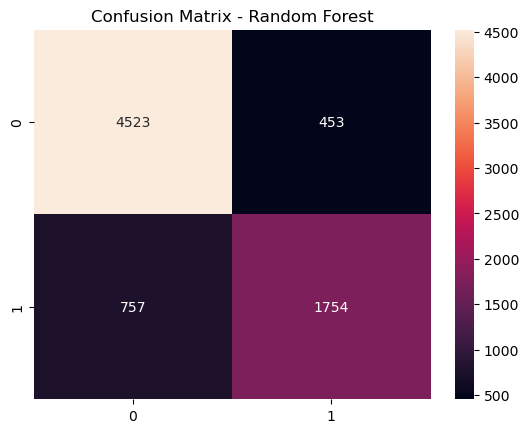

In [38]:
# Plot confusion matrix for Random Forest predictions
sns.heatmap(confusion_matrix(y_test, rf_preds),
            annot=True,  # show numbers inside boxes
            fmt="d")     # display as integers

plt.title("Confusion Matrix - Random Forest")
plt.show()
